In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 10.0)
import torch
import torch.nn as nn
from PIL import Image
from scipy.signal import convolve2d
from skimage.measure import block_reduce, find_contours
from matplotlib.patches import Rectangle
from kural_core.models import *
from kural_core.data_processing import *
from kural_core.functions import *
import pickle
from scipy.misc import imresize
from scipy.ndimage import morphology
from scipy.spatial import ConvexHull
from skimage import measure
from matplotlib import animation, rc
from IPython.display import HTML
from os import listdir

PATH = r'D:\Code\kural_work\movie_generation\data\\'
crop_img_tensor = torch.load(PATH+'crop_img_tensor.variable')

In [47]:
all_files = os.listdir(PATH)
tifs = []
for file in all_files:
    if file[-13:] != 'crop_data.pkl': continue
    tifs.append(file)

In [48]:
tifs

['as02_10m_2s_100ms_25p_crop_data.pkl',
 'as03_30m_2s_50ms_100p_crop_data.pkl',
 'as04_15m_1s_50ms_100p_crop_data.pkl',
 'as05_15m_1s_50ms_100p_crop_data.pkl',
 'as06_15m_1s_50ms_100p_crop_data.pkl',
 'as07_15m_1s_50ms_100p_crop_data.pkl',
 's01_5m_2s_100ms_25p_crop_data.pkl',
 's02_39m_4s_50ms_100p_crop_data.pkl',
 's03_10m_2s_100ms_25p_crop_data.pkl',
 's04_32m_4s_50ms_100p_crop_data.pkl',
 's05_70m_4s_50ms_100p_crop_data.pkl',
 's07_15m_1s_50ms_100p_crop_data.pkl',
 's08_30m_2s_50ms_100p_crop_data.pkl']

In [3]:
tifs = [tifs[i][:-14] + '.tif' for i in range(len(tifs))]

In [4]:
nf_list = []
for tif in tifs:
    img_ = Image.open(PATH+tif)
    nf_list.append(img_.n_frames)

In [5]:
nf = np.stack(nf_list)
nf = np.cumsum(nf)
print(nf)

[ 301 1202 2103 3004 3905 4806 4949 5527 5828 6297 7324 8225 9126]


In [12]:
crop_img_tensor.shape

torch.Size([9126, 1, 128, 128])

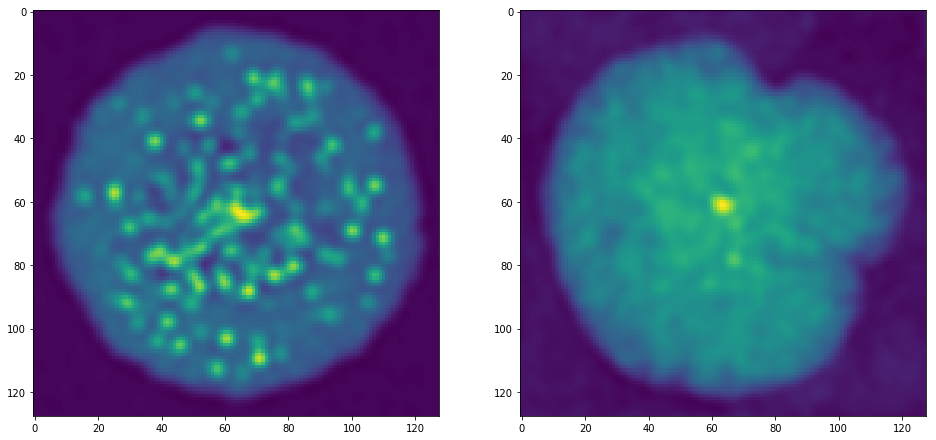

In [29]:
fig, ax = plt.subplots(1,2,figsize=[16,8])
idx = np.random.choice(nf)
ax[0].imshow(crop_img_tensor[idx-1,0])
ax[1].imshow(crop_img_tensor[idx,0])
plt.show()

In [6]:
ds = Conv_AE_RNN_ImageDataset(crop_img_tensor,nf)
tmp_dl = torch.utils.data.DataLoader(ds,batch_size=10)

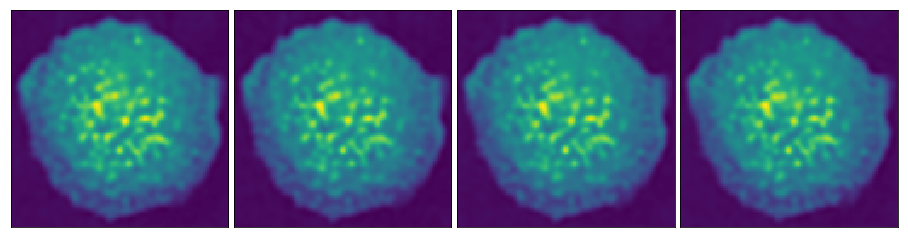

In [64]:
fig, ax = plt.subplots(1,4,figsize=[16,4])
idx = np.random.choice(len(ds))
for i in range(4):
    ax[i].imshow(ds[idx][i,0])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.subplots_adjust(hspace=0,wspace=0)
plt.show()

In [72]:
torch.eye(10,requires_grad=True)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], requires_grad=True)

In [2]:
em_model = ConvolutionalAutoencoderModel()
em_model.load_state_dict(torch.load('C:\\Users\\joshu\\Documents\\fastai\\courses\\kural_work\\convolutional_autoencoder_model.pth'))
em_model.eval()
em_model = em_model.cuda()

In [12]:
rnn_length = 10
ds = Conv_AE_RNN_ImageDataset(crop_img_tensor,nf,rnn_length=rnn_length)
embeddedMovies = torch.zeros((len(ds),rnn_length,128))
for i in range(len(ds)):
    for j in range(rnn_length):
        embeddedMovies[i,j] = em_model.convolution(ds[i][j:j+1].cuda()).data.cpu().view(128)

NameError: name 'nf' is not defined

In [9]:
with open(PATH+'embeddedMovies_10.pickle','wb') as f:
    pickle.dump(embeddedMovies,f)    

In [3]:
with open(PATH+'embeddedMovies_10.pickle','rb') as f:
    embeddedMovies = pickle.load(f)

In [49]:
rnn_length = 10
seq_len = rnn_length-1
n_hidden = 2048
n_layers = 1
clip = 100
ds = torch.utils.data.TensorDataset(embeddedMovies)
train_idx, val_idx = RandomIndicesForKFoldValidation(len(ds), 0, K=5, rand_seed=42, nORp=1)
bs = 30
train_dl = torch.utils.data.DataLoader(ds,batch_size=bs, sampler=SubsetSampler(train_idx, shuffle=True),drop_last=True)
val_dl = torch.utils.data.DataLoader(ds,batch_size=bs, sampler=SubsetSampler(val_idx),drop_last=True)
model = Conv_AE_RNN_Model(n_hidden,n_layers,bs).cuda()
lr_start = 4e-3
opt = optim.Adam(model.parameters(),lr=lr_start)
train_loss = []
val_loss = []
criterion = nn.MSELoss()

In [50]:
model.load_state_dict(torch.load('C:\\Users\\joshu\\Documents\\fastai\\courses\\kural_work\\conv_ae_rnn_model_tmp.pth'))

In [9]:
# @do_profile(follow=[])
# def profile_fit():
restarts = 1
lr_start = 3e-3
lr_end = 1e-6
# lr_end = lr_start
for restart in range(restarts):
    cycles = 20
    epochs = 100
    print(f'restart number {restart+1} out of {restarts}')
#     if len(train_loss)>0: opt = optim.SGD(model.parameters(),lr=lr_start,momentum=0.9)
    # lr_div = (lr_start/lr_end)**(1/epochs)
    time_list = []
    epoch_time_list = None
    cycle_print_str = 'Cycle: 0 ~ Remaining total: Unknown'
    print(cycle_print_str,end='')
    for cycle in range(cycles):
        ts = time.clock()
#         if cycle>0: epochs = epochs*2
        lr_start = lr_start*(0.99)
        epoch_print_str = f' ~ Epoch: 0 ~ Remaining in cycle: {(epochs*np.mean(epoch_time_list) if epoch_time_list is not None else 0):.3g}s'
        print(epoch_print_str, end='')
        epoch_time_list = []
        for epoch in range(epochs):
            ets = time.clock()
            opt.param_groups[0]['lr'] = lr_end + 0.5*(lr_start-lr_end)*(1+math.cos(cycle/cycles*np.pi))
    #         lr /= lr_div
            running_loss = 0.0
            model.train()
            for data, in train_dl:
                x_train = data.cuda()
                opt.zero_grad()
                y_pred = model(x_train[:,:seq_len])
                loss = criterion(y_pred[:,-1].view(-1,128),x_train[:,-1].view(-1,128))
                loss.backward()
                _ = torch.nn.utils.clip_grad_norm_(model.lstm.parameters(), clip)
                _ = torch.nn.utils.clip_grad_norm_(model.reshape_layer.parameters(), clip)
                opt.step()
                running_loss += loss.item()
            train_loss.append(running_loss/len(train_dl))

            running_loss = 0.0
            model.eval()
            with torch.no_grad():
                for data, in val_dl:
                    x_val = data.cuda()
                    y_pred = model(x_val[:,:seq_len])
                    running_loss += criterion(y_pred[:,-1].view(-1,128),x_val[:,-1].view(-1,128)).item()
                val_loss.append(running_loss/len(val_dl))
            epoch_time_list.append(time.clock()-ets)
            if epoch_print_str: 
                for _ in range(len(epoch_print_str)):
                    print('\b',end='')
                epoch_time = (epochs-(epoch+1))*np.mean(epoch_time_list)
                epoch_print_str = f' ~ Epoch: {epoch+1:2d}/{epochs} ~ Remaining in cycle: {int(epoch_time//3600)}h{int(epoch_time//60)-60*int(epoch_time//3600)}m{epoch_time%60:02.0f}s'
                print(epoch_print_str,end='')
        time_list.append(time.clock()-ts)
        if cycle_print_str: 
            for _ in range(len(cycle_print_str)+len(epoch_print_str)):
                print('\b',end='')
        remaining_time = (cycles-(cycle+1))*np.mean(time_list)
        cycle_print_str = f'Cycle: {cycle+1:3d}/{cycles} ~ Remaining total: {int(remaining_time//3600)}h{int(remaining_time//60)-60*int(remaining_time//3600)}m{remaining_time%60:02.0f}s'
        print(cycle_print_str,end='')
    for _ in range(len(cycle_print_str)):
                print('\b',end='')
    print(f'Spent {int(sum(time_list)//60)}m {sum(time_list)%60:2.0f}s doing {cycles*epochs} total steps for an average of {sum(time_list)/cycles/epochs:3.1f}s per step.')
        
#         return (train_loss, val_loss)

# torch.save(model.state_dict(),'C:\\Users\\joshu\\Documents\\fastai\\courses\\kural_work\\kMeans_autoencoder_model.pth')
                                       

restart number 1 out of 1
Spent 521m 46s doing 2000 total steps for an average of 15.7s per step.


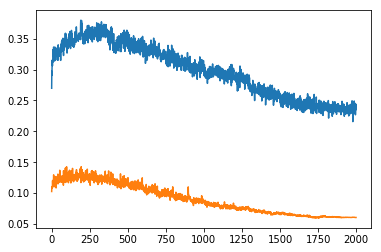

In [10]:
slc = slice(0,len(train_loss))
plt.plot(train_loss[slc])
plt.plot(val_loss[slc])
plt.show()

In [51]:
torch.save(model.state_dict(),'C:\\Users\\joshu\\Documents\\fastai\\courses\\kural_work\\conv_ae_rnn_model.pth')

In [56]:
torch.sum(model.h==0)

tensor(124615, device='cuda:0')

In [52]:
x_train[:,-1,:].view(10,128)

tensor([[-2.9407,  2.2365,  0.7019,  ...,  0.9233, -0.8471,  1.8354],
        [-0.6960,  0.8608, -0.1261,  ..., -0.5614,  1.2381,  2.5851],
        [-1.6897,  1.2760, -0.6670,  ...,  0.4123,  1.1012,  3.8717],
        ...,
        [ 0.8128, -1.5732, -1.2183,  ..., -1.0738, -1.1260,  1.8074],
        [ 2.4989,  0.4359, -0.2551,  ...,  0.0077, -1.5774,  0.6817],
        [-2.5185,  1.6054,  2.3618,  ...,  0.0341,  1.2734,  1.7612]],
       device='cuda:0')

In [76]:
ds[1][0].shape

torch.Size([4, 128])

In [83]:
torch.all(hidden==0)

tensor(1, device='cuda:0', dtype=torch.uint8)

In [111]:
img.shape

torch.Size([1, 1, 128, 128])

In [41]:
ds[0].shape

torch.Size([10, 128])

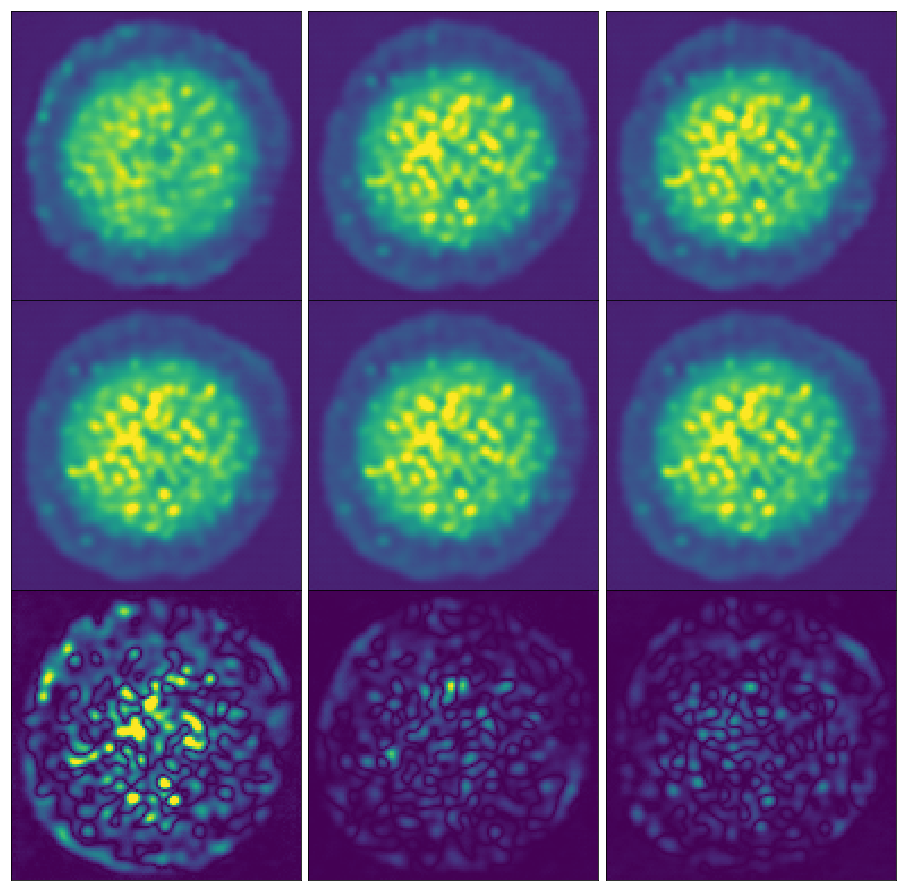

In [6]:
dl = val_dl
bidx = np.random.choice(bs)
idx = np.random.choice(len(dl))
idl = iter(dl)
for _ in range(idx+1):
    tmp = next(idl)[0]
# idx=20
fig, ax = plt.subplots(3,3,figsize=[16,16])
res = model(tmp[:,0:rnn_length-1].view(bs,rnn_length-1,128).cuda())
for j in range(3):
    img = em_model.deconvolution(res[bidx,j+rnn_length-1-3].view(1,128,1,1)).data.cpu()
    im = ax[0,j].imshow(img[0,0])
    im.set_clim((0,.04))
    ax[0,j].set_xticks([])
    ax[0,j].set_yticks([])
for j in range(3):
    img = em_model.deconvolution(tmp[bidx,j+rnn_length-3].view(1,128,1,1).cuda()).data.cpu()
    im = ax[1,j].imshow(img[0,0])
    im.set_clim((0,.04))
    ax[1,j].set_xticks([])
    ax[1,j].set_yticks([])
for j in range(3):
    img1 = em_model.deconvolution(tmp[bidx,j+rnn_length-1-3+1].view(1,128,1,1).cuda()).data.cpu()[0,0]
    img2 = em_model.deconvolution(res[bidx,j+rnn_length-1-3].view(1,128,1,1)).data.cpu()[0,0]
    im = ax[2,j].imshow(torch.abs(img1-img2))
    im.set_clim((0,.01))
    ax[2,j].set_xticks([])
    ax[2,j].set_yticks([])
plt.subplots_adjust(hspace=0,wspace=0)
plt.show()

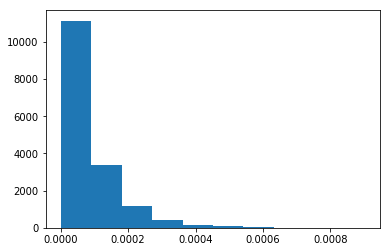

In [61]:
plt.hist(im.get_array().data.flatten())
plt.show()

In [110]:
[ 301 1202 2103 3004 3905 4806 4949 5527 5828 6297 7324 8225 9126]

torch.Size([10, 10, 128])

In [44]:
start = 20
model.eval()
ds = torch.utils.data.TensorDataset(embeddedMovies)
gen_movie = []
act_movie = []
tmp = ds[start:start+bs][0]
res = tmp
for i in range(rnn_length-1):
    gen_movie.append(em_model.deconvolution(tmp[0,i].view(1,128,1,1).cuda()).data.cpu()[0,0])
    act_movie.append(em_model.deconvolution(tmp[0,i].view(1,128,1,1).cuda()).data.cpu()[0,0])
for i in range(100):
    out = model(res[:, i:i+seq_len].cuda()).data.cpu()
    res = torch.cat((res,out[:,-1:]),dim=1)
    img = em_model.deconvolution(res[0,-1].view(1,128,1,1).cuda()).data.cpu()
    gen_movie.append(img[0,0])
    tmp = ds[i+start][0]
    act_movie.append(em_model.deconvolution(tmp[-1].view(1,128,1,1).cuda()).data.cpu()[0,0])

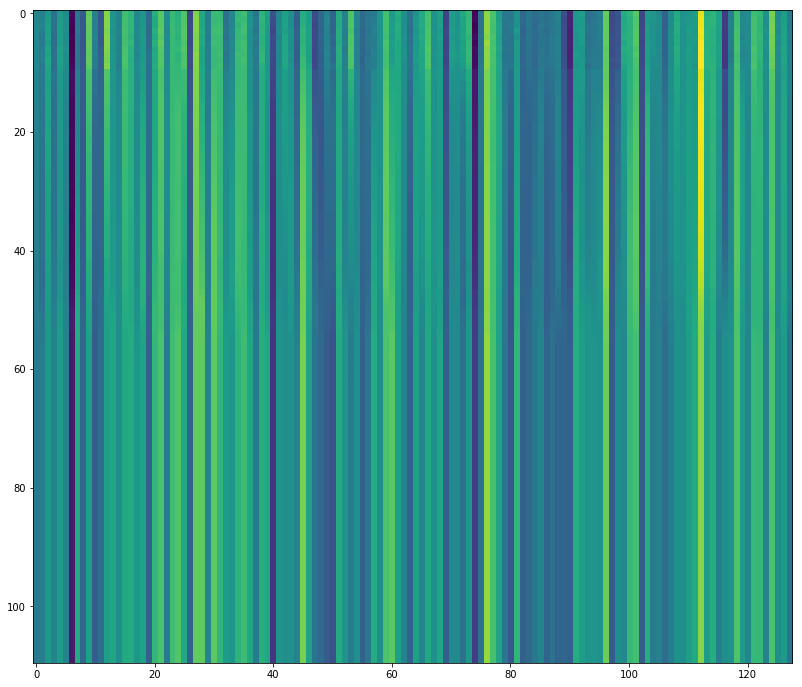

In [35]:
plt.figure(figsize=[100,12])
plt.imshow(res[0].data)

In [46]:
fig,ax = plt.subplots(1,2,figsize=[16,8])
# ax[0].set_xlim((0, 128))
# ax[0].set_ylim((0, 128))
# ax[1].set_xlim((0, 128))
# ax[1].set_ylim((0, 128))
ax[0].set_title('Generated Movie')
ax[1].set_title('Actual Movie (compressed and decompressed)')
im0 = ax[0].imshow(gen_movie[0], animated=True)
im1 = ax[1].imshow(act_movie[0], animated=True)
# plt.subplots_adjust(wspace=0)
plt.colorbar(mappable=im0, ax=ax[0], shrink=0.5)
plt.colorbar(mappable=im1, ax=ax[1], shrink=0.5)
def init():
    im0.set_array([[]])
    im1.set_array([[]])
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    return im0, im1,
def animate(i,y0,y1):
    im0.set_array(y0[i])
    im1.set_array(y1[i])
    im0.set_clim((0, 0.02))
    im1.set_clim((0, 0.02))
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    fig.suptitle(f'Frame {i}')
    return  im0, im1, 
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=100+rnn_length-1, fargs=[gen_movie, act_movie], interval=50, blit=False)
plt.close()
HTML(anim.to_html5_video())